In [120]:
import os
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import from_networkx
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

In [121]:

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]


folder_path = 'client_subgraphs'
sub_data_list = []

for filename in os.listdir(folder_path):
    if filename.endswith('.gml'):
      
        file_path = os.path.join(folder_path, filename)
        g = nx.read_gml(file_path)

        subgraph_nodes = list(g.nodes)
        subgraph_nodes = [int(node) for node in subgraph_nodes]  # Convert to integer if they are not

        sub_edge_index, _ = subgraph(subgraph_nodes, data.edge_index, relabel_nodes=True)

        sub_data = Data(x=data.x[subgraph_nodes], edge_index=sub_edge_index, y=data.y[subgraph_nodes])
        sub_data_list.append(sub_data)


In [122]:
print(sub_data_list[0])
print(sub_data_list[0].x.shape)

Data(x=[18, 1433], edge_index=[2, 58], y=[18])
torch.Size([18, 1433])


In [5]:
# #plot subgraph 0 to make sure it looks right
# import matplotlib.pyplot as plt
# import networkx as nx
# from torch_geometric.utils import to_networkx

# G = to_networkx(sub_data_list[82], to_undirected=False)
# plt.figure(figsize=(20,20))
# nx.draw(G, with_labels=True, node_size=15, node_color='g', edge_color='b')
# plt.show()


In [31]:

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First convolutional layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # Second convolutional layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [33]:
#keep a  list of training and validation loss per epoch for each subgraph
train_losses = []
val_losses = []

In [34]:
import numpy as np
def train_val_split(data):
        #handle labels with only one sample
    # `data.x` contains the node features and `data.y` contains the labels

    # Count the occurrences of each label in the dataset
    label_counts = torch.bincount(data.y)

    # Find the labels that appear only once (single occurrence)
    single_occurrence_labels = torch.nonzero(label_counts == 1).flatten()

    # Initialize empty lists to store samples
    single_sample_label = []
    other_label = []

    # Separate samples based on labels
    for i, label in enumerate(data.y):
        if label in single_occurrence_labels:
            single_sample_label.append(i)
        else:
            other_label.append(i)

    # Convert the lists of sample indices into tensors
    single_sample_label = torch.tensor(single_sample_label)
    other_label = torch.tensor(other_label)

    # Extract the corresponding node features and labels
    single_sample_x = data.x[single_sample_label]
    single_sample_y = data.y[single_sample_label]
    other_x = data.x[other_label]
    other_y = data.y[other_label]
    
    other_x_train, other_x_test, other_y_train, other_y_test = train_test_split(other_x, other_y, test_size=0.2, random_state=42)

    # Add single_sample_x and single_sample_y to the training set
    combined_x_train = torch.cat((other_x_train, single_sample_x), dim=0)
    combined_y_train = torch.cat((other_y_train, single_sample_y), dim=0)
    
    return combined_x_train, combined_y_train, other_x_test, other_y_test
                    

 


In [123]:
import torch



def transductive_split(data, train_percent=0.8, val_percent=0.1):
    """
    Split graph data into training, validation, and testing sets for transductive learning.
    :param data: PyG Data object
    :param train_percent: Percentage of nodes to be used for training
    :param val_percent: Percentage of nodes to be used for validation
    :return: data object with train_mask, val_mask, and test_mask attributes added
    """
    num_nodes = data.num_nodes
    train_size = int(train_percent * num_nodes)
    val_size = int(val_percent * num_nodes)

    # Create a random permutation of node indices
    perm = torch.randperm(num_nodes)

    # Create masks for training, validation, and testing nodes
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[perm[:train_size]] = True
    val_mask[perm[train_size:train_size + val_size]] = True
    test_mask[perm[train_size + val_size:]] = True

    # Add masks to data object
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data


In [ ]:
for i in range(0, 100):
    
    sub_data = sub_data_list[i]
    #split sub_data.x and sub_data.y into train and validation, but keep the same edge_index
    train_x, train_y, val_x, val_y = transductive_split(sub_data)
    
    continue
    sub_data_train = Data(x=train_x, edge_index=sub_data.edge_index, y=train_y)
    sub_data_val = Data(x=val_x, edge_index=sub_data.edge_index, y=val_y)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    
    client_train_losses = []
    client_val_losses = []
    
    for epoch in range(200):
        model = model.train()
        optimizer.zero_grad()
        out = model(sub_data_train)
        loss = F.nll_loss(out, sub_data_train.y)
        loss.backward()
        optimizer.step()
        
        client_train_losses.append(loss.item())
        
        #calculate validation loss
        model = model.eval()
        out_val = model(sub_data_val)
        loss = F.nll_loss(out_val, sub_data_val.y)
        client_val_losses.append(loss.item())
        
        
    train_losses.append(client_train_losses)
    val_losses.append(client_val_losses)
    # print out metrics
    #calculate final training accuracy
    true_labels = sub_data_train.y
    _, pred = out.max(1)
    train_correct = pred.eq(true_labels).sum().item()
    print("final training loss: ", loss.item(), " for subgraph ", i)
    print("final training accuracy: ", train_correct / len(true_labels), " for subgraph ", i)
    print()
    #calculate validation accuracy and loss
    true_labels = sub_data_val.y
    _, pred = out_val.max(1)
    val_correct = pred.eq(true_labels).sum().item()
    
    
    print("final validation loss: ", loss.item(), " for subgraph ", i)
    print("final validation accuracy: ", val_correct / len(true_labels), " for subgraph ", i)
    print("------------------------------------------------------------")

In [124]:
# splitting the subgraphs into train test and val 
for i in range(0, 100):
    sub_data = sub_data_list[i]
    sub_data = transductive_split(sub_data)


print(torch.sum(sub_data_list[4].train_mask).item())  # Number of training nodes
print(torch.sum(sub_data_list[4].val_mask).item())    # Number of validation nodes
print(torch.sum(sub_data_list[4].test_mask).item()) 

10
1
2


In [125]:
from torch_geometric.nn import GCNConv
    
    
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training) # p = 0.25
        x = self.conv2(x, edge_index)
        return x
    


model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)

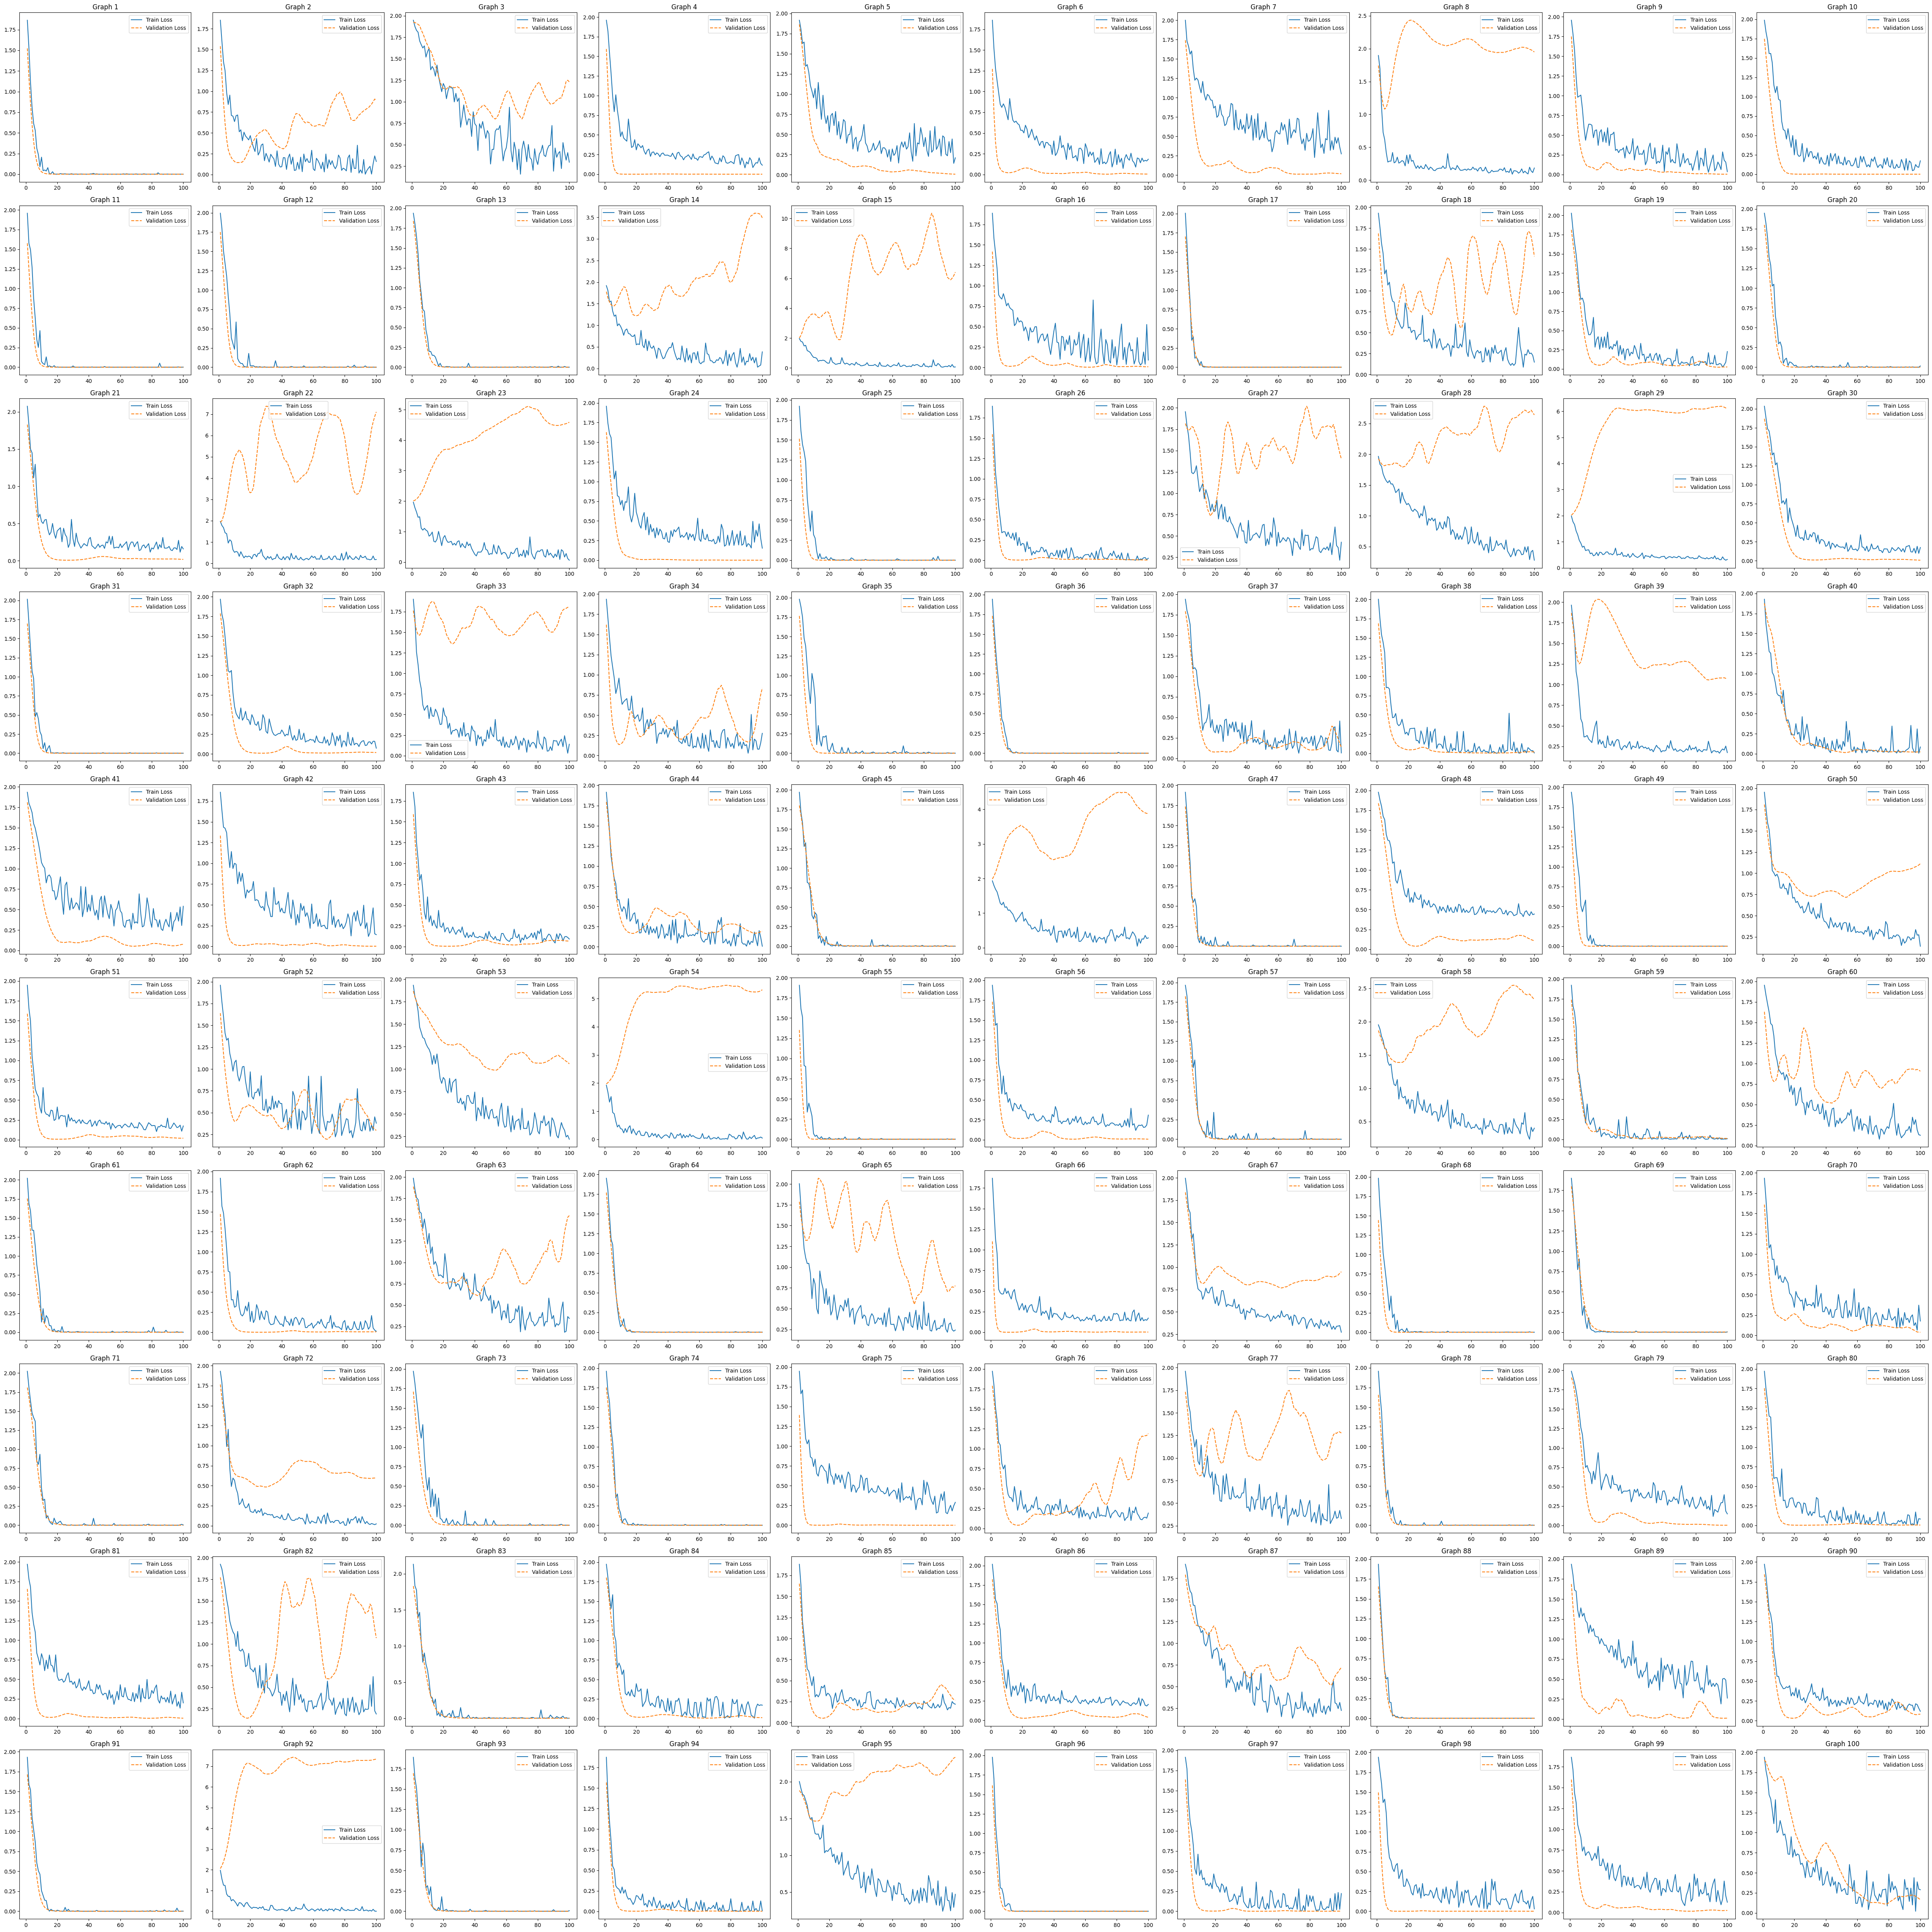

In [140]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(50, 50))

def train(sub_data, model, optimizer, criterion):
      model.train()
      optimizer.zero_grad() 
      out = model(sub_data.x, sub_data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward() 
      optimizer.step() 
      return loss

def test(sub_data, criterion, model):
      model.eval()
      out = model(sub_data.x, sub_data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[sub_data.test_mask] == sub_data.y[sub_data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(sub_data.test_mask.sum())  # Derive ratio of correct predictions.
      test_loss = criterion(out[sub_data.test_mask], sub_data.y[sub_data.test_mask])  # Compute validation loss
      
      return test_loss, test_acc


def validate(sub_data, model, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not compute gradients during this step
        out = model(sub_data.x, sub_data.edge_index)  # Forward pass
        pred = out.argmax(dim=1)  # Get predicted classes
        val_correct = pred[sub_data.val_mask] == sub_data.y[sub_data.val_mask]  # Compare with ground-truth
        val_loss = criterion(out[sub_data.val_mask], sub_data.y[sub_data.val_mask])  # Compute validation loss
        val_acc = int(val_correct.sum()) / int(sub_data.val_mask.sum())  # Compute validation accuracy
    return val_loss.item(), val_acc  # Return validation loss and accuracy


for i in range(len(sub_data_list)):
    sub_data = sub_data_list[i]
    
    model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = [] 
    val_losses = []    

    # Training loop for each epoch (adjust the range as needed)
    for epoch in range(1, 101):
        train_loss = train(sub_data, model, optimizer, criterion)  # Assuming 'train' returns a loss
        val_loss, _ = validate(sub_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
    
    test_loss, test_acc = test(sub_data, criterion, model)
    row = i // 10
    col = i % 10

    # Plotting on specific subplot
    axs[row, col].plot(range(1, 101), [loss.item() for loss in train_losses], label='Train Loss')
    axs[row, col].plot(range(1, 101), val_losses, label='Validation Loss', linestyle='dashed')
    axs[row, col].set_title(f'Graph {i+1}')
    axs[row, col].legend()
    
plt.tight_layout()
plt.show()

